In [1]:
%matplotlib notebook

In [2]:
import json

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt

from kafka import KafkaConsumer


In [3]:
def readFromKafka(topic):
    consumer = KafkaConsumer(topic, 
                             bootstrap_servers="master1:6667", 
                             auto_offset_reset='earliest', 
                             enable_auto_commit=True, 
                             value_deserializer=lambda x: x.decode('utf-8'), 
                             consumer_timeout_ms=10000)

    records = []
    for message in consumer:
        record = json.loads(message.value)
        record["KafkaTimestamp"] = message.timestamp
        records.append(record)

    # Normalize timestamp
    df = json_normalize(records)
    
    base = df["Timestamp"].loc[0:0][0]
    df["EventTimestamp0"] = (df["Timestamp"] - base) / 1000.0
    df["ReceivedTimestamp0"] = (df["KafkaTimestamp"] - base ) / 1000.0

    print(f"Records: {len(records)}")
    return df

In [4]:
from matplotlib.ticker import MaxNLocator

def plotComparision(data, height=14):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True,figsize=(10,height))

    ax1.scatter( x='EventTimestamp0', y='ClientID', c='ClientID', data=data, marker='o', alpha=0.5, cmap="tab20")
    ax1.title.set_text('Event Timestamp (zero normalized)')

    ax2.scatter( x='ReceivedTimestamp0',y='ClientID', c='ClientID', data=data, marker='o', alpha=0.5, cmap="tab20")
    ax2.title.set_text('Received Timestamp (zero normalized)')

    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()

## Analyse a 10 session dataset from 10 clients

In [5]:
df = readFromKafka('sessions-10')
df.head()

Records: 255


,ClientID,Data.Errors,Data.Values,EventID,KafkaTimestamp,Kind,SessionID,Timestamp,EventTimestamp0,ReceivedTimestamp0
0,2,0,17,1,1540726486053,m,1de64fb8-55de-494c-885a-364dcf35f37d,1540726486041,0.000,0.012
1,2,1,34,2,1540726486072,m,1de64fb8-55de-494c-885a-364dcf35f37d,1540726486063,0.022,0.031
2,8,0,65,1,1540726486628,m,b1ca39c2-7b90-4287-be81-4908e32d771c,1540726486626,0.585,0.587
3,9,0,79,1,1540726489990,d,c320e635-32c0-4bd8-af3c-86b854048d03,1540726489989,3.948,3.949
4,5,0,58,1,1540726490014,m,5cd8e458-208c-48d5-9bd5-f52303e14ec4,1540726490004,3.963,3.973


### Distribution of session lenghts

<IPython.core.display.Javascript object>


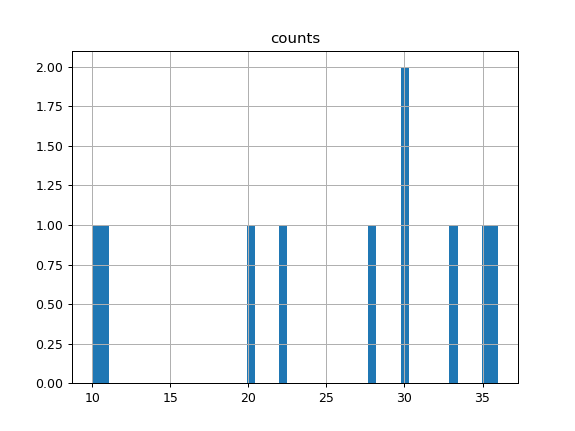

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1202137b8>]],
      dtype=object)

In [6]:
hist = df.groupby(by="SessionID").size().reset_index(name='counts').sort_values(by="counts")
hist.hist(bins=50)

### Comparison of Event time and Receoved Time

<IPython.core.display.Javascript object>


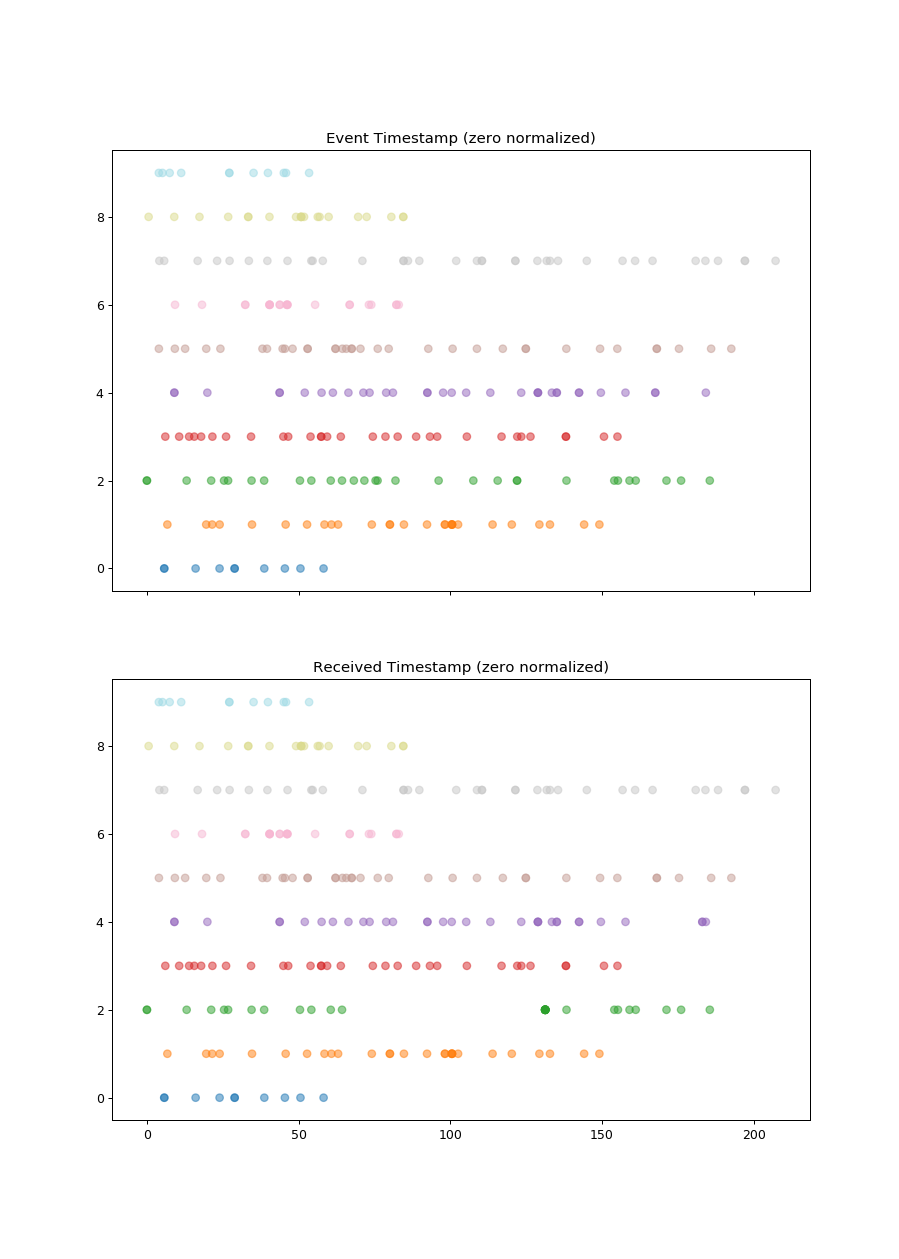

In [7]:
plotComparision(df)

**Session 2 shows a "network outage" after 60 seconds of about 65 seconds**

<IPython.core.display.Javascript object>


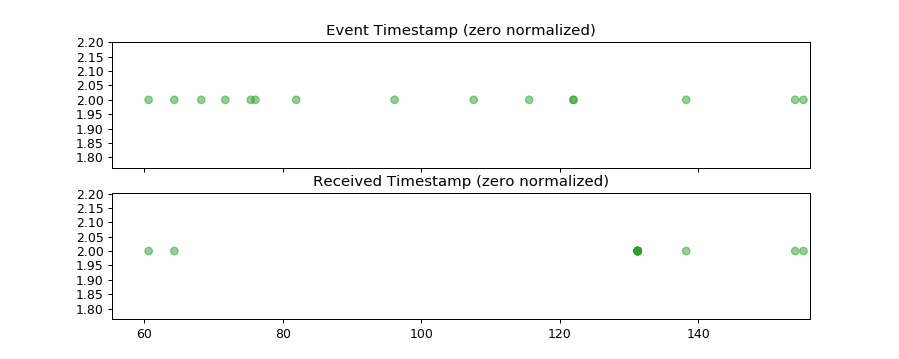

In [8]:
plotComparision(df, 4)

**The data was buffered by the client and sent as fast as possible at about 131.25 sec**

<IPython.core.display.Javascript object>


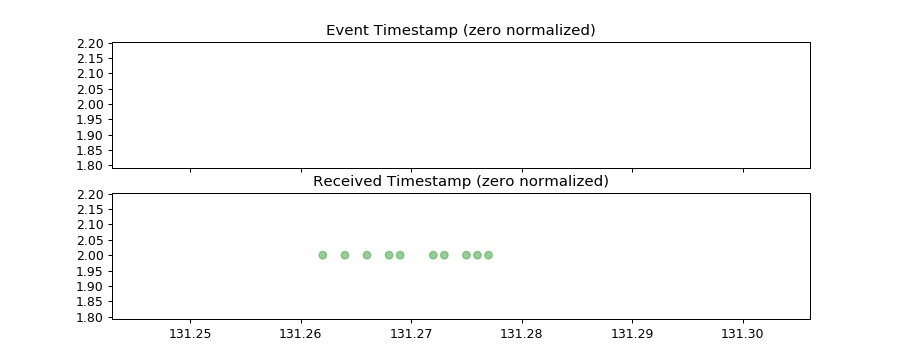

In [9]:
plotComparision(df, 4)

## Analyze a 100 sessions dataset from 10 clients

In [10]:
df = readFromKafka('sessions-100')

Records: 2428


<IPython.core.display.Javascript object>


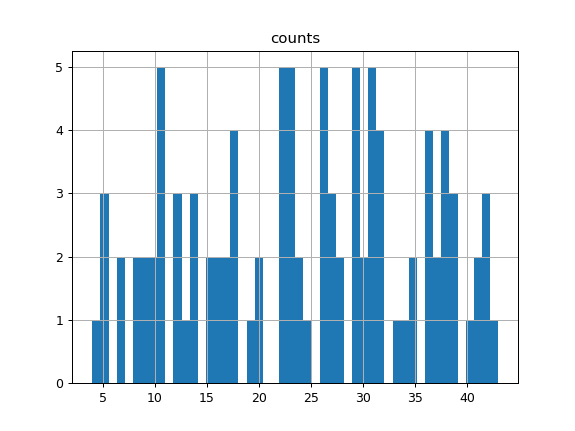

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1228fdc18>]],
      dtype=object)

In [11]:
hist = df.groupby(by="SessionID").size().reset_index(name='counts').sort_values(by="counts")
hist.hist(bins=50)

<IPython.core.display.Javascript object>


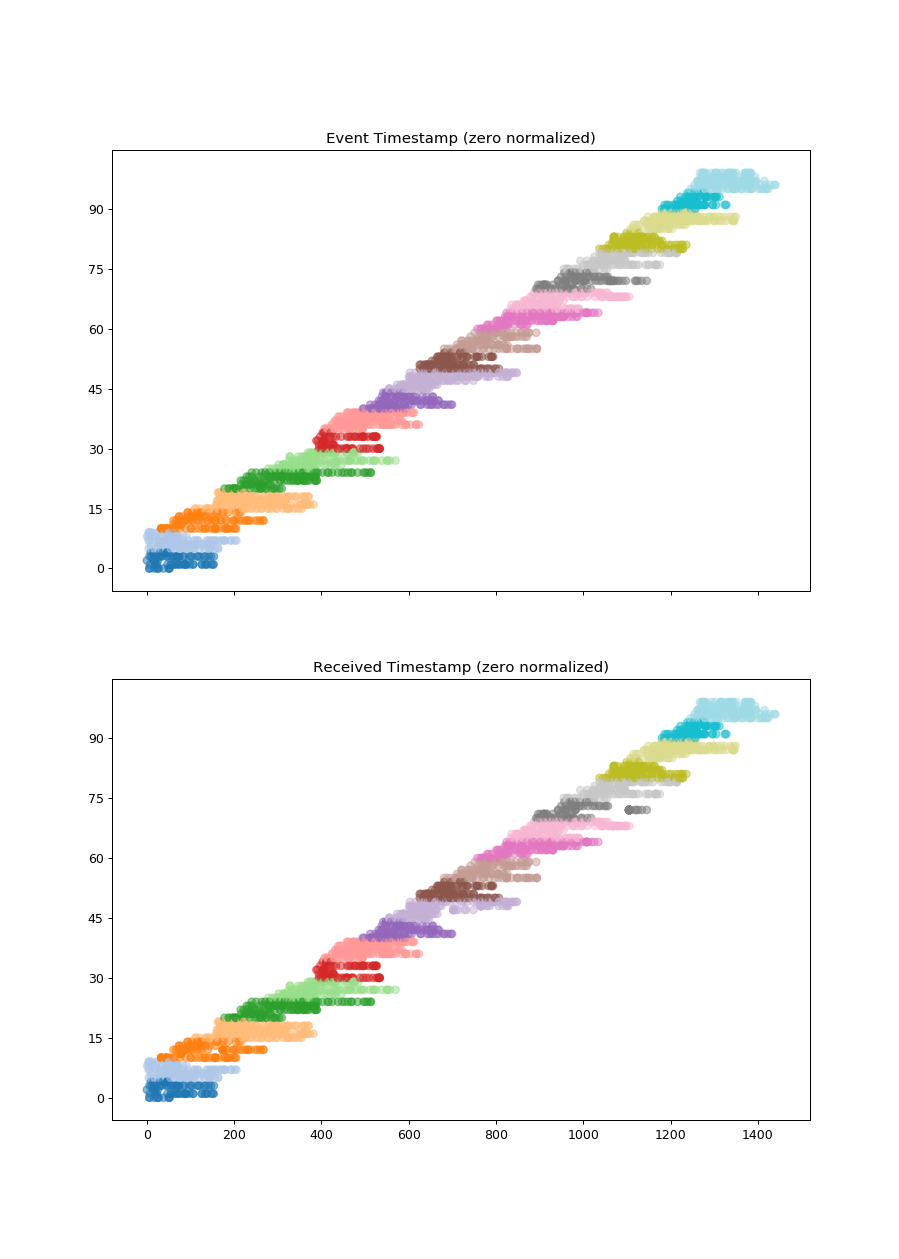

In [12]:
plotComparision(df)